In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm
import gc

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
#load dataset
df_tr = pd.read_csv('/content/drive/MyDrive/assignment_2/data_transaction.csv') 

In [4]:
df_id = pd.read_csv('/content/drive/MyDrive/assignment_2/data_identity.csv')

In [5]:
gc.collect()

114

In [6]:
# merge 2 datasets 
df = pd.concat([df_tr, df_id], axis = 1)

In [7]:
Fraud_df = df[df["isFraud"] == 1]
#sorry, but my computer and colab are so slow and don't work at all 
# so, I used just 100000 rows of data
#  count target class "Fraud" much lower than "Not Fraud", so I deleted only "Not Fraud" class rows  
Not_fraud_df = df[df["isFraud"] == 0][:100000]
df = pd.concat([Fraud_df,Not_fraud_df],axis = 0)
# shuffle dataset
df = df.sample(frac=1).reset_index(drop=True)

In [8]:
target = df["isFraud"]
# drop useless features
df = df.drop(["TransactionID", "TransactionDT", "isFraud"], axis = 1)
#Label encoding of all categorical features
for i in df.columns:
    if df[i].dtype == np.dtype(object):
        le = preprocessing.LabelEncoder()
        df[i] = le.fit_transform(df[i])
# scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df = scaler.fit_transform(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
gc.collect()

50

In [10]:
# to tensor!
df = torch.torch.from_numpy(pd.DataFrame(df).values).to(torch.float32)
# mask data
Ind_df = torch.isnan(df)
# merge data and mask
data = torch.hstack([df,Ind_df])
# train_test_split in my interpretation :)
X_train = data[:int(len(data)*0.8)]
X_test = data[int(len(data)*0.8):]

In [11]:
y_train = target[:int(len(data)*0.8)]
y_test = target[int(len(data)*0.8):]

In [12]:
# dataloader for models
data_loader = DataLoader(torch.nan_to_num(X_train, nan=1.0), batch_size=300)
test_data_loader = DataLoader(torch.nan_to_num(X_test, nan=1.0), batch_size=300)

In [13]:
gc.collect()

250

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Autoenoders

# Undercomplete autoencoder

In [15]:
class autoencoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, input_size//2),
            nn.ReLU(True),
            nn.Linear(input_size//2, input_size//3),
            nn.Linear(input_size//3, input_size//4),
            nn.Tanh(),
            nn.Linear(input_size//4, latent_dim)
          )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, input_size//4),
            nn.ReLU(True),
            nn.Linear(input_size//4, input_size//3),
            nn.Linear(input_size//3, input_size//2),
            nn.Tanh(),
            nn.Linear(input_size//2, input_size)
          )
        self.encoder.apply(self.__init_weights)
        self.decoder.apply(self.__init_weights)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        
        
    
    def encode(self,input):
        return self.encoder(input)
    
    def __init_weights(self,m):
      #Init the weights (optional)
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

In [16]:
learning_rate = 0.001
num_epochs = 20
AE = autoencoder(862,200).to(device)
print(AE)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(AE.parameters(),lr=learning_rate, momentum = 0.5)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=862, out_features=431, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=431, out_features=287, bias=True)
    (3): Linear(in_features=287, out_features=215, bias=True)
    (4): Tanh()
    (5): Linear(in_features=215, out_features=200, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=200, out_features=215, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=215, out_features=287, bias=True)
    (3): Linear(in_features=287, out_features=431, bias=True)
    (4): Tanh()
    (5): Linear(in_features=431, out_features=862, bias=True)
  )
)


In [18]:
temp_loss = 100000000
best_on_test_model = 0
best_epo_test = 0
ae_loss = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    test_loss = 0.0
    for X in data_loader:
        X = X[0].to(device)

        optimizer.zero_grad()
        # forward
        output = AE(X)
        loss = criterion(output, X)

        # backward
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    ae_loss.append(loss.item())
        
        
        #test
    for t in test_data_loader: 
        t = t[0].to(device)
        test_output = AE(t)
        test_loss = criterion(test_output, t)

        test_loss+= test_loss.item()
            
    if test_loss <= temp_loss:
        temp_loss = test_loss
        best_on_test_model = AE.state_dict()
        best_epo_test = epoch
        
    print('train loss:  epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
    print('test loss:  epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, test_loss.item()))
    print()
print("loss on test: ",str(temp_loss))
print("best epoch on test: ",str(best_epo_test))
torch.save(best_on_test_model, "/content/drive/MyDrive/AE_model")

train loss:  epoch [1/20], loss:0.8630
test loss:  epoch [1/20], loss:1.1568

train loss:  epoch [2/20], loss:0.8284
test loss:  epoch [2/20], loss:1.0941

train loss:  epoch [3/20], loss:0.7912
test loss:  epoch [3/20], loss:1.0180

train loss:  epoch [4/20], loss:0.7410
test loss:  epoch [4/20], loss:0.9157

train loss:  epoch [5/20], loss:0.6854
test loss:  epoch [5/20], loss:0.8041

train loss:  epoch [6/20], loss:0.6310
test loss:  epoch [6/20], loss:0.6992

train loss:  epoch [7/20], loss:0.5829
test loss:  epoch [7/20], loss:0.6091

train loss:  epoch [8/20], loss:0.5430
test loss:  epoch [8/20], loss:0.5364

train loss:  epoch [9/20], loss:0.5114
test loss:  epoch [9/20], loss:0.4808

train loss:  epoch [10/20], loss:0.4871
test loss:  epoch [10/20], loss:0.4395

train loss:  epoch [11/20], loss:0.4688
test loss:  epoch [11/20], loss:0.4094

train loss:  epoch [12/20], loss:0.4550
test loss:  epoch [12/20], loss:0.3877

train loss:  epoch [13/20], loss:0.4448
test loss:  epoch 

autoencoders loss

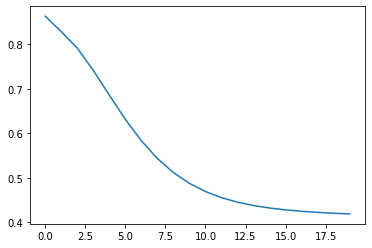

In [19]:
import matplotlib.pyplot as plt
# plot loss
plt.plot(ae_loss)
plt.show()

Results of Autoencoder

In [17]:
# load my model from drive
AE.load_state_dict(torch.load("/content/drive/MyDrive/AE_model"))
AE.eval()
train_data = []
test_data = []
# creating dataset for classification
for i in data_loader:
  i = i.to(device)
  train_data.append(AE(i))
for i in test_data_loader:
  i = i.to(device)
  test_data.append(AE(i))

In [18]:
# tensors to numpy
X_train_AE = torch.cat(train_data).cpu().detach().numpy()
X_test_AE = torch.cat(test_data).cpu().detach().numpy()
gc.collect()

50

In [19]:
#finally , well known type and our dataset!!!
X_train_AE_df = pd.DataFrame(X_train_AE)
X_test_AE_df = pd.DataFrame(X_test_AE)

# X_train_AE_df.to_csv('/content/drive/MyDrive/assignment_2/X_train_AE.csv', index=False)
# X_test_AE_df.to_csv('/content/drive/MyDrive/assignment_2/X_test_AE.csv', index=False)

Classification on autoencoders dataset

In [23]:
# RandomForest model
from sklearn.ensemble import RandomForestClassifier
clf_ae = RandomForestClassifier(max_depth=3)
clf_ae.fit(X_train_AE_df , y_train)
y_pred = clf_ae.predict(X_test_AE_df)

In [24]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     20032
           1       0.98      0.26      0.41      4101

    accuracy                           0.87     24133
   macro avg       0.92      0.63      0.67     24133
weighted avg       0.89      0.87      0.84     24133



# Classification on statistical imputing aproach dataset

In [25]:
# creating dataset
stat_df = pd.concat([Fraud_df,Not_fraud_df],axis = 0)
stat_df = stat_df.sample(frac=1).reset_index(drop=True)

In [26]:
target = stat_df["isFraud"]

stat_df = stat_df.drop(["TransactionID", "TransactionDT", "isFraud"], axis = 1)
# LabelEncoding
for i in stat_df.columns:
    if stat_df[i].dtype == np.dtype(object):
        le = preprocessing.LabelEncoder()
        stat_df[i] = le.fit_transform(stat_df[i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
# nan imputing by puting column mean instead
stat_df = stat_df.apply(lambda x: x.fillna(x.mean()),axis=0)

In [28]:
gc.collect()

44

In [29]:
# train_test_split
X_train_stat = stat_df[:int(len(stat_df)*0.8)]
X_test_stat = stat_df[int(len(stat_df)*0.8):]
y_train_stat = target[:int(len(stat_df)*0.8)]
y_test_stat = target[int(len(stat_df)*0.8):]

In [30]:
# classification
clf_ae_stat = RandomForestClassifier(max_depth=3)
clf_ae_stat.fit(X_train_stat , y_train_stat)
y_pred = clf_ae_stat.predict(X_test_stat)

In [31]:
print(classification_report(y_test_stat,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     20022
           1       0.90      0.82      0.86      4111

    accuracy                           0.95     24133
   macro avg       0.93      0.90      0.92     24133
weighted avg       0.95      0.95      0.95     24133



# Regularized autoencoder

All further code almost same as in Undercomplete autoencoder part, so comments also same

In [32]:
class reg_autoencoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(reg_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, input_size//2),
            nn.ReLU(True),
            nn.Linear(input_size//2, input_size//3),
            nn.Linear(input_size//3, input_size//4),
            nn.Tanh(),
            nn.Linear(input_size//4, latent_dim)
          )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, input_size//4),
            nn.ReLU(True),
            nn.Linear(input_size//4, input_size//3),
            nn.Linear(input_size//3, input_size//2),
            nn.Tanh(),
            nn.Linear(input_size//2, input_size)
          )
        self.encoder.apply(self.__init_weights)
        self.decoder.apply(self.__init_weights)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        
        
    
    def encode(self,input):
        return self.encoder(input)
    
    def __init_weights(self,m):
      #Init the weights (optional)
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

In [33]:
learning_rate = 0.001
num_epochs = 30
reg_AE = reg_autoencoder(862,200).to(device)
print(reg_AE)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(reg_AE.parameters(),lr=learning_rate)

reg_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=862, out_features=431, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=431, out_features=287, bias=True)
    (3): Linear(in_features=287, out_features=215, bias=True)
    (4): Tanh()
    (5): Linear(in_features=215, out_features=200, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=200, out_features=215, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=215, out_features=287, bias=True)
    (3): Linear(in_features=287, out_features=431, bias=True)
    (4): Tanh()
    (5): Linear(in_features=431, out_features=862, bias=True)
  )
)


In [17]:
temp_loss = 100000000
best_on_test_model = 0
best_epo_test = 0
rae_loss = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    test_loss = 0.0
    for X in data_loader:
        X = X[0].to(device)

        optimizer.zero_grad()
        # forward
        output = reg_AE(X)
        loss = criterion(output, X)

        regul = 0.0
        for param in reg_AE.parameters():
            regul += torch.abs((torch.norm(param, 1)))
        regul *= 0.00001

        loss += regul

        # backward
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    rae_loss.append(loss.item())        

        #test
    for t in test_data_loader: 
        t = t[0].to(device)
        test_output = reg_AE(t)
        test_loss = criterion(test_output, t)

        test_loss+= test_loss.item()
            
    if test_loss <= temp_loss:
        temp_loss = test_loss
        best_on_test_model = reg_AE.state_dict()
        best_epo_test = epoch
        
    print('train loss:  epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
    print('test loss:  epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, test_loss.item()))
    print()
print("loss on test: ",str(temp_loss))
print("best epoch on test: ",str(best_epo_test))
torch.save(best_on_test_model, "/content/drive/MyDrive/RAE_model")

train loss:  epoch [1/30], loss:1.0507
test loss:  epoch [1/30], loss:0.3430

train loss:  epoch [2/30], loss:1.3865
test loss:  epoch [2/30], loss:0.1348

train loss:  epoch [3/30], loss:0.8718
test loss:  epoch [3/30], loss:0.1216

train loss:  epoch [4/30], loss:0.7763
test loss:  epoch [4/30], loss:0.1340

train loss:  epoch [5/30], loss:0.7694
test loss:  epoch [5/30], loss:0.0956

train loss:  epoch [6/30], loss:0.7150
test loss:  epoch [6/30], loss:0.0990

train loss:  epoch [7/30], loss:0.6654
test loss:  epoch [7/30], loss:0.0982

train loss:  epoch [8/30], loss:0.6647
test loss:  epoch [8/30], loss:0.1134

train loss:  epoch [9/30], loss:0.6342
test loss:  epoch [9/30], loss:0.1080

train loss:  epoch [10/30], loss:0.7398
test loss:  epoch [10/30], loss:0.2080

train loss:  epoch [11/30], loss:0.7302
test loss:  epoch [11/30], loss:0.1877

train loss:  epoch [12/30], loss:0.6535
test loss:  epoch [12/30], loss:0.1255

train loss:  epoch [13/30], loss:0.9108
test loss:  epoch 

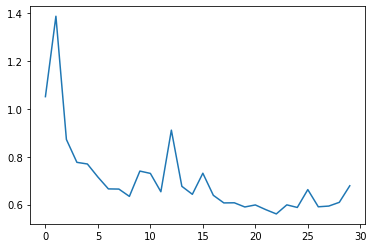

In [18]:
import matplotlib.pyplot as plt

plt.plot(rae_loss)
plt.show()

Classification on Reg Autoencoders dataset

In [34]:
reg_AE.load_state_dict(torch.load("/content/drive/MyDrive/RAE_model"))
reg_AE.eval()
train_data = []
test_data = []
for i in data_loader:
  i = i.to(device)
  train_data.append(reg_AE(i))
for i in test_data_loader:
  i = i.to(device)
  test_data.append(reg_AE(i))

In [35]:
X_train_RAE = torch.cat(train_data).cpu().detach().numpy()
X_test_RAE = torch.cat(test_data).cpu().detach().numpy()
gc.collect()

209

In [36]:
X_train_RAE_df = pd.DataFrame(X_train_RAE)
X_test_RAE_df = pd.DataFrame(X_test_RAE)

In [22]:
from sklearn.ensemble import RandomForestClassifier
clf_rae = RandomForestClassifier(max_depth=3)
clf_rae.fit(X_train_RAE_df , y_train)
y_pred = clf_rae.predict(X_test_RAE_df)

In [23]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91     20060
           1       0.64      0.16      0.25      4073

    accuracy                           0.84     24133
   macro avg       0.75      0.57      0.58     24133
weighted avg       0.82      0.84      0.80     24133



# Variational autoencoder

In [16]:
class VAE(nn.Module):
    def __init__(self, input_size=862, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, input_size//2)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x[0]*x[1])
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
# Start training
cri = nn.MSELoss()
vae_loss = []
num_epochs = 30
for epoch in range(num_epochs):
    for i, x in enumerate(data_loader):
        # Forward pass

        x1 = x[:,:431]
        mask = x[:,431:]
        rec, mu, log_var = model(x)
        
        reconst_loss = cri(rec*mask, x1)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 157 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
    vae_loss.append(reconst_loss)

torch.save(model.state_dict(), "/content/drive/MyDrive/VAE_model")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch[1/30], Step [157/322], Reconst Loss: 0.6908, KL Div: 0.0018
Epoch[1/30], Step [314/322], Reconst Loss: 0.6765, KL Div: 0.0041
Epoch[2/30], Step [157/322], Reconst Loss: 0.6902, KL Div: 0.0006
Epoch[2/30], Step [314/322], Reconst Loss: 0.6763, KL Div: 0.0008
Epoch[3/30], Step [157/322], Reconst Loss: 0.6902, KL Div: 0.0004
Epoch[3/30], Step [314/322], Reconst Loss: 0.6763, KL Div: 0.0001
Epoch[4/30], Step [157/322], Reconst Loss: 0.6902, KL Div: 0.0000
Epoch[4/30], Step [314/322], Reconst Loss: 0.6763, KL Div: 0.0000
Epoch[5/30], Step [157/322], Reconst Loss: 0.6902, KL Div: 0.0000
Epoch[5/30], Step [314/322], Reconst Loss: 0.6763, KL Div: 0.0000
Epoch[6/30], Step [157/322], Reconst Loss: 0.6902, KL Div: -0.0000
Epoch[6/30], Step [314/322], Reconst Loss: 0.6763, KL Div: -0.0000
Epoch[7/30], Step [157/322], Reconst Loss: 0.6902, KL Div: 0.0000
Epoch[7/30], Step [314/322], Reconst Loss: 0.6763, KL Div: -0.0000
Epoch[8/30], Step [157/322], Reconst Loss: 0.6902, KL Div: -0.0000
Epoch[

In [27]:
plt_arr = []
for i in vae_loss:
  plt_arr.append(i.detach().numpy())

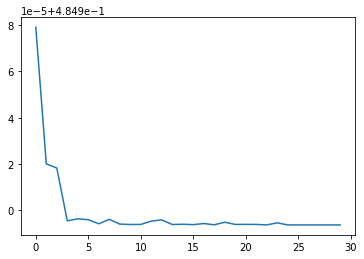

In [28]:
import matplotlib.pyplot as plt

plt.plot(plt_arr)
plt.show()

Classification on VAE dataset

In [29]:
model.load_state_dict(torch.load("/content/drive/MyDrive/VAE_model"))
model.eval()
train_data = []
test_data = []
for i in data_loader:
  X ,  _, _ = model(i)
  train_data.append(X)
for i in test_data_loader:
  X ,  _, _ = model(i)
  test_data.append(X)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [31]:
X_train_VAE = torch.cat(train_data).detach().numpy()
X_test_VAE = torch.cat(test_data).detach().numpy()
gc.collect()

4721

In [33]:
X_train_VAE_df = pd.DataFrame(X_train_VAE)
X_test_VAE_df = pd.DataFrame(X_test_VAE)

In [31]:
from sklearn.ensemble import RandomForestClassifier
clf_rae = RandomForestClassifier(max_depth=3)
clf_rae.fit(X_train_RAE_df , y_train)
y_pred = clf_rae.predict(X_test_RAE_df)

In [32]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91     20060
           1       0.62      0.13      0.22      4073

    accuracy                           0.84     24133
   macro avg       0.73      0.56      0.56     24133
weighted avg       0.81      0.84      0.79     24133



# Reduce the dimenssion of the data using Principal component analysis and Linear Discriminant Analysis and compare the impact on selected machine learning model

Undercomplete autoencoder

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

PCA

In [31]:
# PCA
pca = PCA(n_components = 20)
pca_AE_train_df = pca.fit_transform(X_train_AE_df)
pca_AE_test_df = pca.transform(X_test_AE_df)

clf_AE = RandomForestClassifier(max_depth = 3)
clf_AE.fit(pca_AE_train_df, y_train)

y_pred = clf_AE.predict(pca_AE_test_df)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     19966
           1       0.95      0.27      0.42      4167

    accuracy                           0.87     24133
   macro avg       0.91      0.63      0.67     24133
weighted avg       0.88      0.87      0.84     24133



LDA

In [28]:
# LDA
lda = LinearDiscriminantAnalysis(n_components=1)
lda_AE_train_df = lda.fit_transform(X_train_AE_df, y_train)
lda_AE_test_df = lda.transform(X_test_AE_df)

clf_AE = RandomForestClassifier(max_depth = 3)
clf_AE.fit(lda_AE_train_df, y_train)

y_pred = clf_AE.predict(lda_AE_test_df)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     19966
           1       0.95      0.81      0.88      4167

    accuracy                           0.96     24133
   macro avg       0.96      0.90      0.93     24133
weighted avg       0.96      0.96      0.96     24133



Regularized autoencoder

PCA

In [37]:
pca = PCA(n_components = 20)
pca_RAE_train_df = pca.fit_transform(X_train_RAE_df)
pca_RAE_test_df = pca.transform(X_test_RAE_df)

clf_RAE = RandomForestClassifier(max_depth = 3)
clf_RAE.fit(pca_RAE_train_df, y_train)

y_pred = clf_RAE.predict(pca_RAE_test_df)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91     19966
           1       0.70      0.07      0.12      4167

    accuracy                           0.83     24133
   macro avg       0.77      0.53      0.52     24133
weighted avg       0.81      0.83      0.77     24133



LDA

In [38]:
lda = LinearDiscriminantAnalysis(n_components=1)
lda_RAE_train_df = lda.fit_transform(X_train_RAE_df, y_train)
lda_RAE_test_df = lda.transform(X_test_RAE_df)

clf_RAE = RandomForestClassifier(max_depth = 3)
clf_RAE.fit(lda_RAE_train_df, y_train)

y_pred = clf_RAE.predict(lda_RAE_test_df)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     19966
           1       0.56      0.34      0.42      4167

    accuracy                           0.84     24133
   macro avg       0.72      0.64      0.66     24133
weighted avg       0.82      0.84      0.82     24133

